
## Importing data

In [ ]:
import numpy as np
import pandas as pd
from itertools import groupby
from pandas.api.types import is_datetime64_ns_dtype

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from joblib import Parallel, delayed
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl

import warnings
warnings.filterwarnings("ignore")

column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score',
}

tolerances = {
    'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360], 
    'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
}

In [1]:
lstm_conv_train = False
ensable_train = False

In [ ]:
def reduce_mem_usage(df):
    
    """ 
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not is_datetime64_ns_dtype(df[col]) and not 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int32)  
            else:
                df[col] = df[col].astype(np.float16)
        
    return df

In [ ]:
def feat_eng(df):
    
    df['series_id'] = df['series_id'].astype('category')
    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df['hour'] = df["timestamp"].dt.hour
    
    df.sort_values(['timestamp'], inplace=True)
    df.set_index('timestamp', inplace=True)
    
    
    df["enmo"] = (df["enmo"]*1000).astype(np.int16)
    df["anglez"] = df["anglez"].astype(np.int16)
    df["anglezdiffabs"] = df["anglez"].diff().abs().astype(np.float32)
    
    for col in ['enmo', 'anglez', 'anglezdiffabs']:
        
        # periods in seconds        
        periods = [60,120,180,360,720,3600] 
        
        for n in periods:
            
            rol_args = {'window':f'{n+5}s', 'min_periods':10, 'center':True}
            
            for agg in ['median', 'mean', 'max', 'min', 'var']:
                df[f'{col}_{agg}_{n}'] = df[col].rolling(**rol_args).agg(agg).astype(np.float32).values
                gc.collect()
            
            if n == max(periods):
                df[f'{col}_mad_{n}'] = (df[col] - df[f'{col}_median_{n}']).abs().rolling(**rol_args).median().astype(np.float32)
            
            df[f'{col}_amplit_{n}'] = df[f'{col}_max_{n}']-df[f'{col}_min_{n}']
            df[f'{col}_amplit_{n}_min'] = df[f'{col}_amplit_{n}'].rolling(**rol_args).min().astype(np.float32).values

            df[f'{col}_diff_{n}_max'] = df[f'{col}_max_{n}'].diff().abs().rolling(**rol_args).max().astype(np.float32)
            df[f'{col}_diff_{n}_mean'] = df[f'{col}_max_{n}'].diff().abs().rolling(**rol_args).mean().astype(np.float32)

    
            gc.collect()
    
    df.reset_index(inplace=True)
    df.dropna(inplace=True)

    return df

In [ ]:
file = '/kaggle/input/zzzs-lightweight-training-dataset-target/Zzzs_train.parquet'

def feat_eng_by_id(idx):
    
    from warnings import simplefilter 
    simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    
    df  = pd.read_parquet(file, filters=[('series_id','=',idx)])
    df['awake'] = df['awake'].astype(np.int8)
    df = feat_eng(df)
    
    return df

### Training and validating 

In [ ]:
series_id  = pd.read_parquet(file, columns=['series_id'])
series_id = series_id.series_id.unique()

print(len(series_id))

In [ ]:
weird_series = ['31011ade7c0a', 'a596ad0b82aa']
# good_series = ["0ef7d94fde99","1087d7b0ff2e", "10f8bc1f7b07", "29c75c018220"]

series_id = [s for s in series_id if s not in weird_series]
# series_id = [s for s in series_id if s in good_series]

In [ ]:
%%time

train = Parallel(n_jobs=-1)(delayed(feat_eng_by_id)(i) for i in series_id)
train = pd.concat(train, ignore_index=True)

In [ ]:
drop_cols = ['series_id', 'step', 'timestamp']

X, y = train.drop(columns=drop_cols+['awake']), train['awake']

gc.collect()

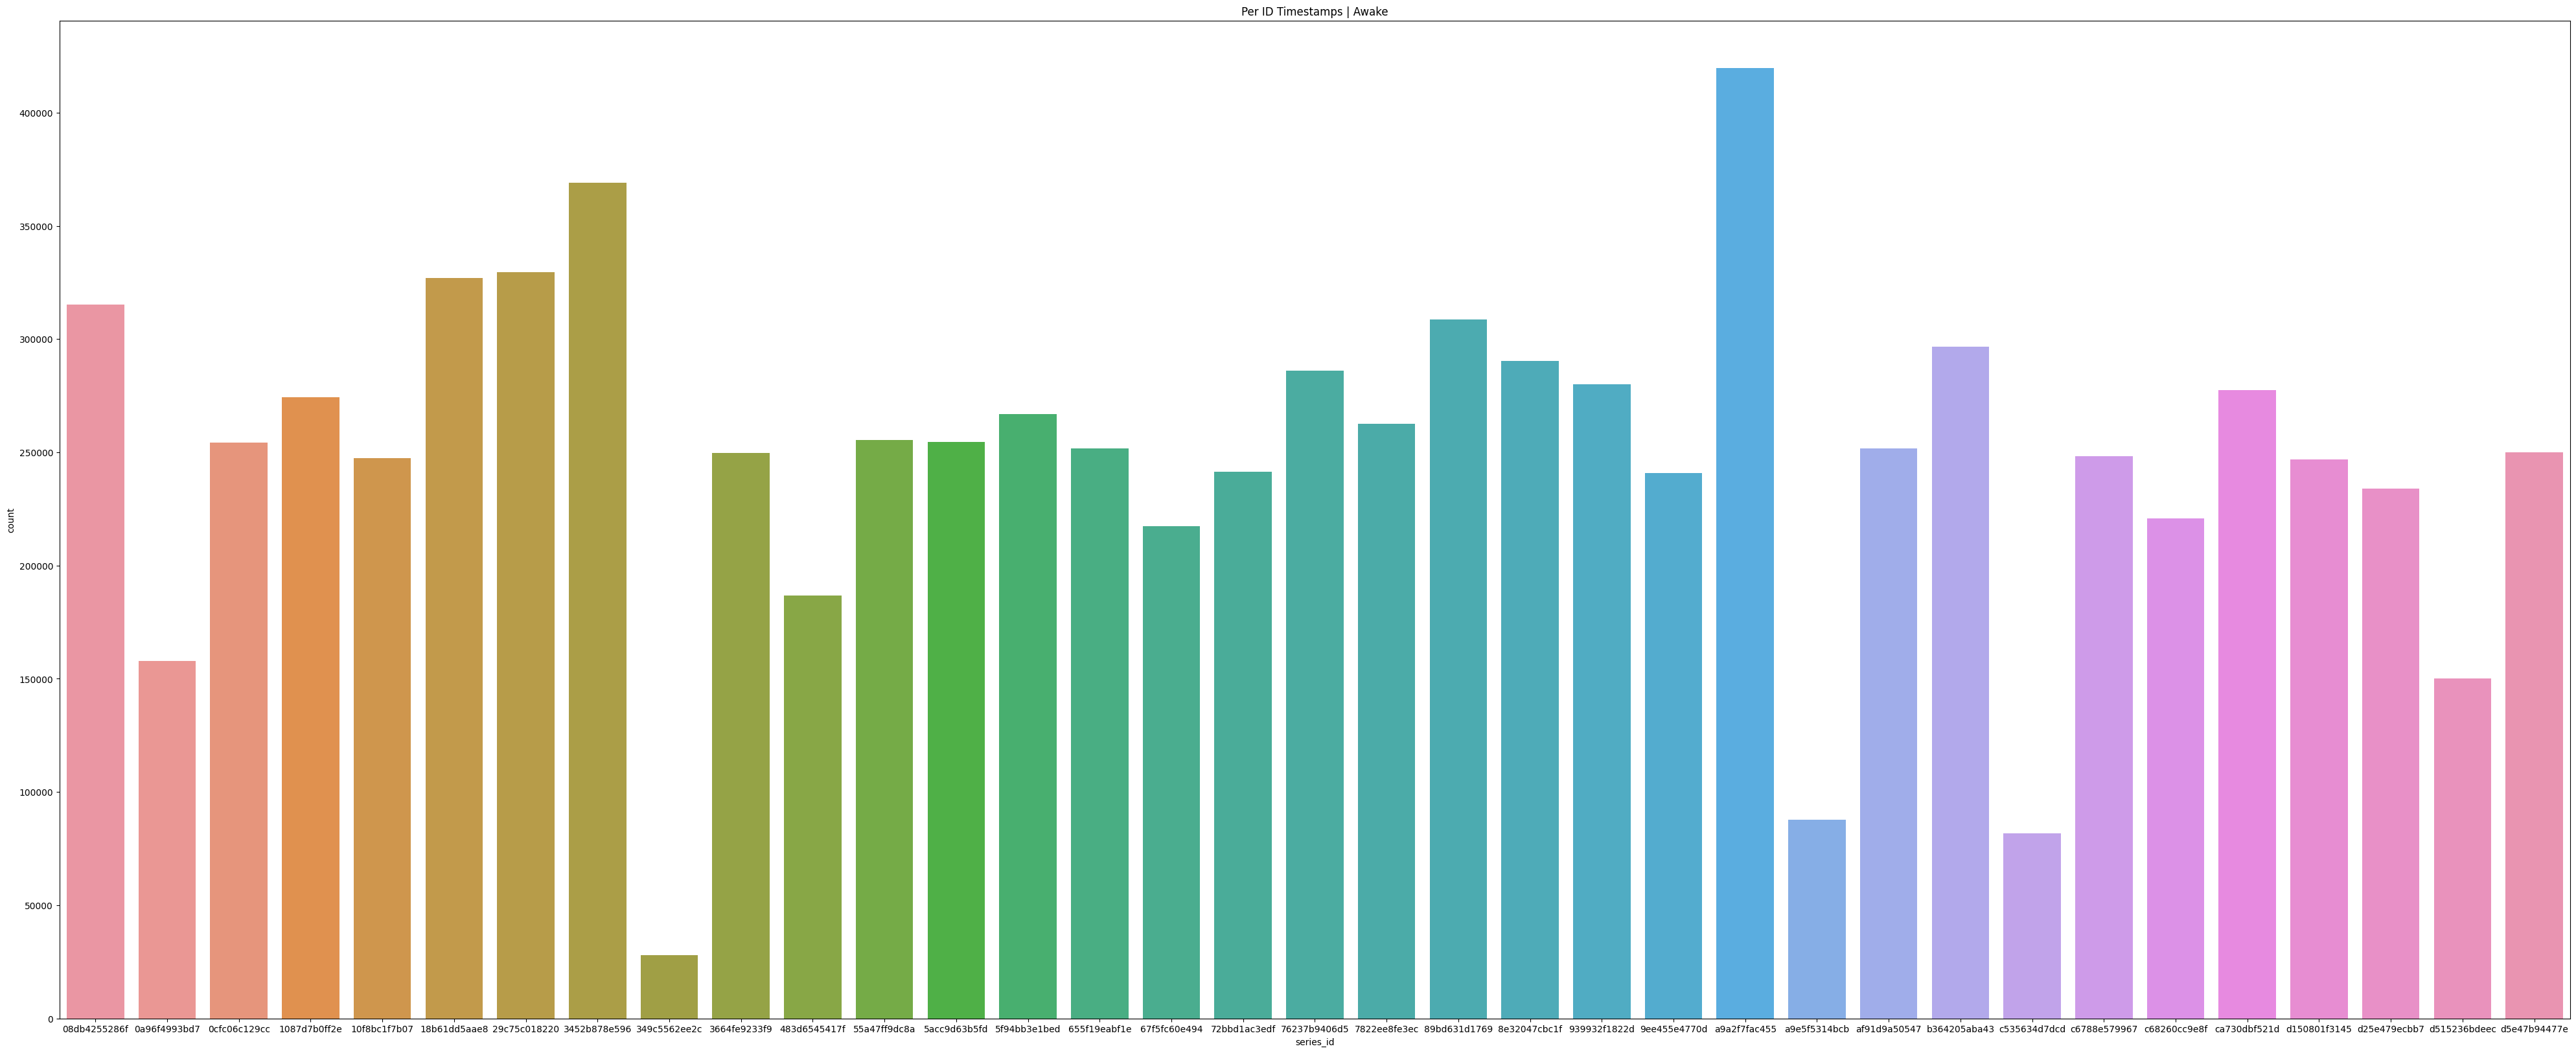

In [ ]:
# Inspect users timestamps
plt.figure(figsize=(50,20))
sns.countplot(x = 'series_id',
              # order = train_df[train_df['awake']==1].series_id.value_counts().index, 
              data = train[train['awake']==1])
plt.title('Per ID Timestamps | Awake')
plt.show()

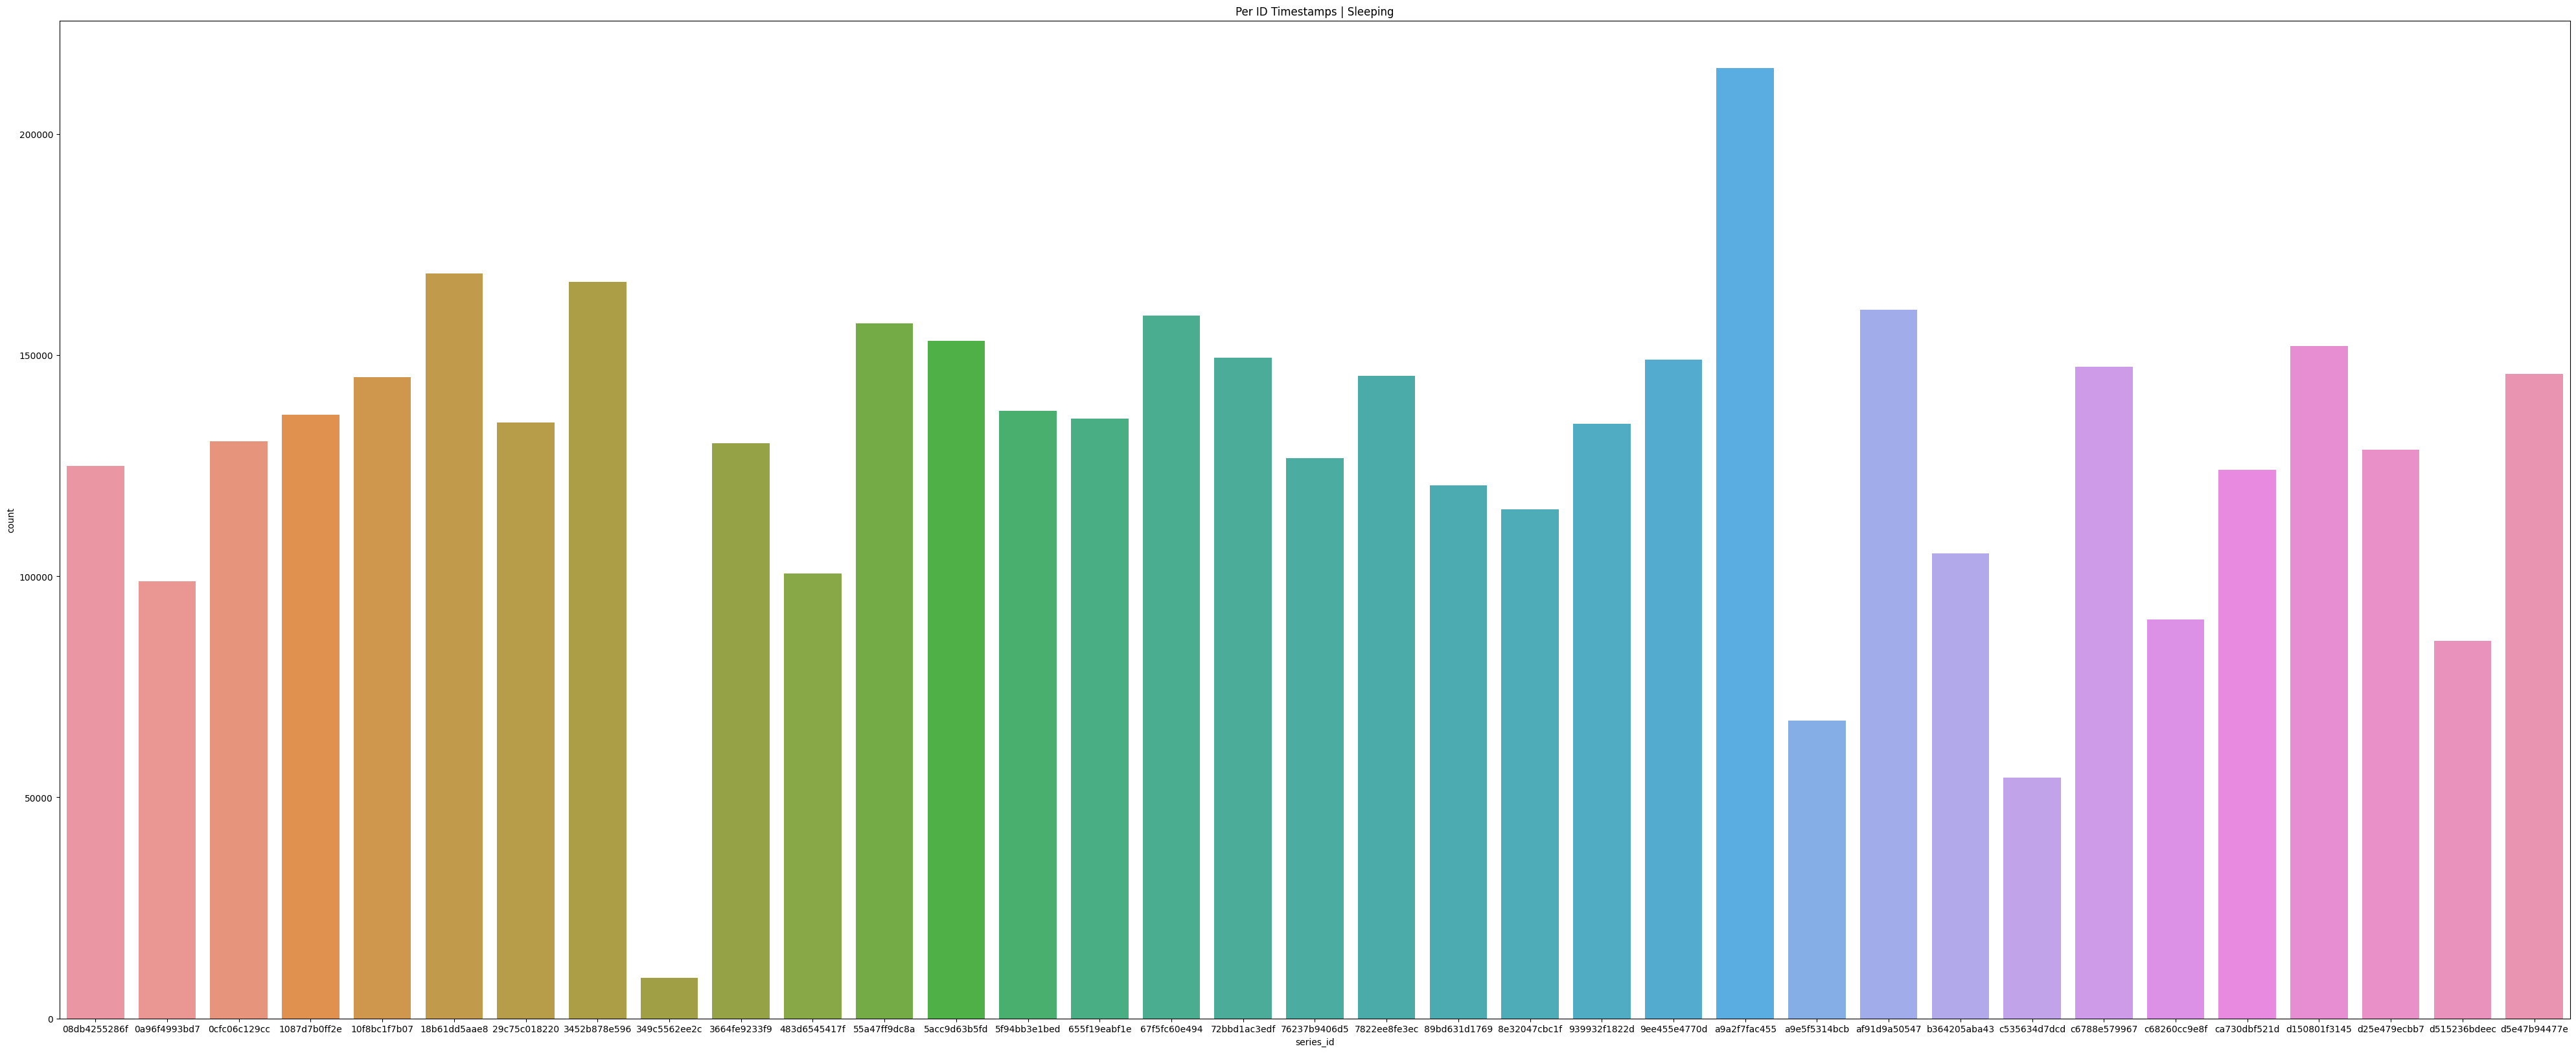

In [ ]:
# Inspect users timestamps
plt.figure(figsize=(50,20))
sns.countplot(x = 'series_id',
              # order = train_df[train_df['awake']==0].series_id.value_counts().index, 
              data = train[train['awake']==0])
plt.title('Per ID Timestamps | Sleeping')
plt.show()

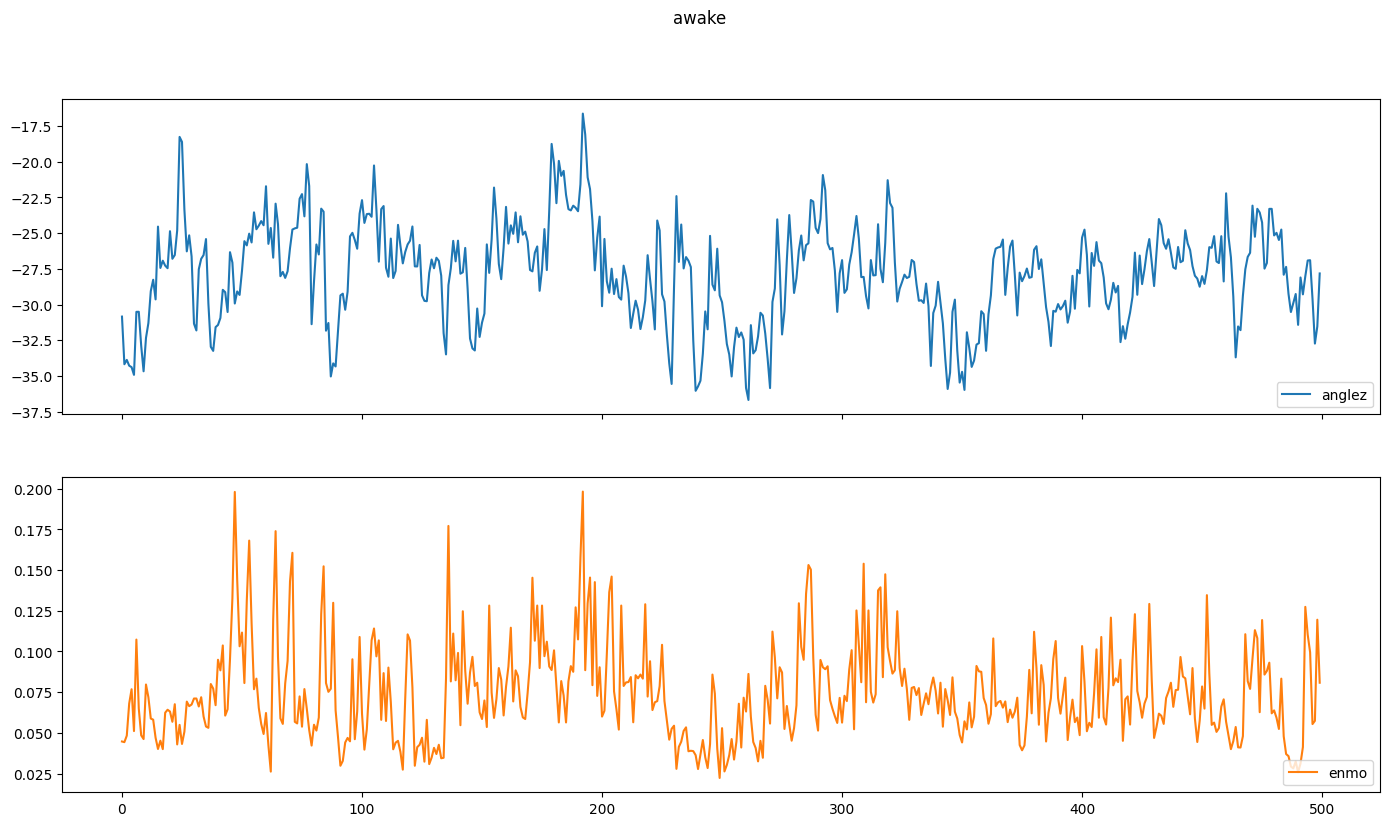

In [ ]:
data = train[train['awake'] == 1][['anglez', 'enmo']][:500]
axis = data.plot(subplots=True, figsize=(17, 9), title='awake')
for ax in axis:
    ax.legend(loc='lower right')

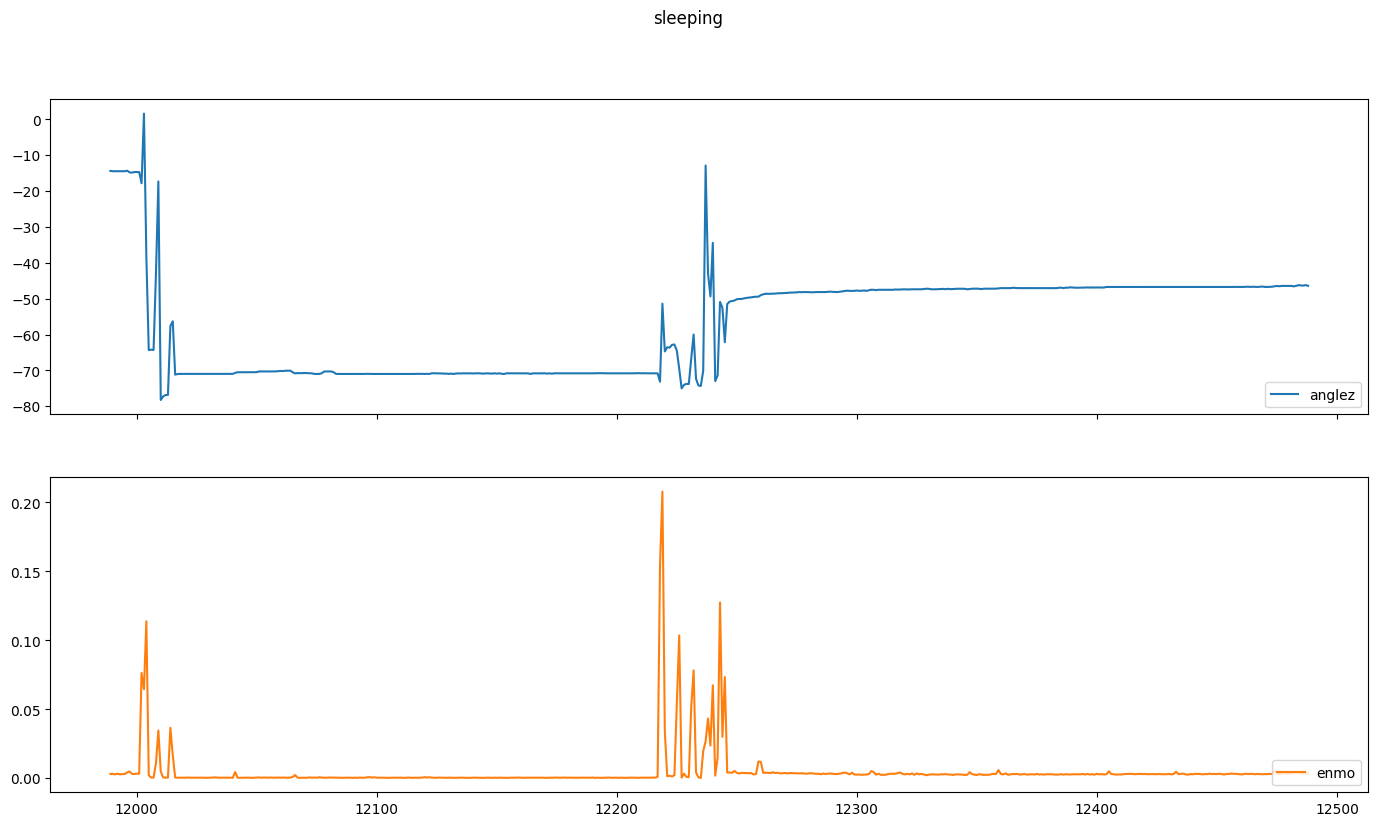

In [ ]:
data = train[train['awake'] == 0][['anglez', 'enmo']][:500]
axis = data.plot(subplots=True, figsize=(17, 9), title='sleeping')
for ax in axis:
    ax.legend(loc='lower right')

### Ensemble Model

In [ ]:
class EnsembleAvgProba():
    
    def __init__(self, classifiers):
        
        self.classifiers = classifiers
    
    def fit(self,X,y):
        
        for classifier in self.classifiers:                
            classifier.fit(X, y)
            gc.collect()
     
    def predict_proba(self, X):
        
        probs = []
        
        for m in self.classifiers:
            probs.append(m.predict_proba(X))
        
        probabilities = np.stack(probs)
        p = np.mean(probabilities, axis=0)
        
        return p 
    
    def predict(self, X):
        
        probs = []
        
        for m in self.classifiers:
            probs.append(m.predict(X))
        
        probabilities = np.stack(probs)
        p = np.mean(probabilities, axis=0)
        
        return p.round()

In [ ]:
import xgboost as xgb


# Training classifier

model_ensamble = EnsembleAvgProba(classifiers=[
                    lgb.LGBMClassifier(random_state=42),
                    GradientBoostingClassifier(n_estimators=100,max_depth=5,min_samples_leaf=300,random_state=42),
                    RandomForestClassifier(n_estimators=500, min_samples_leaf=300, random_state=42, n_jobs=-1),
                    xgb.XGBClassifier(n_estimators=520,objective="binary:logistic", learning_rate=0.02, max_depth=7, random_state=42)    ]
                )

In [ ]:
%%time
if ensable_train: 
    model_ensamble.fit(X, y)

CPU times: user 42min 41s, sys: 1.81 s, total: 42min 42s
Wall time: 42min 11s


### Idea of building sequences for a Neural Network model

```python

minutes_per_timeseries = 1 

# 5 seconds per timestamp (sample)
limit = int(minutes_per_timeseries * 60 / 5)  # = 2 * 60 seconds / 5 seconds = 24 = limit
def limit_sequence(x,limit=limit):
        return x.head(limit)

        
def build_sequences_train(df,limit=limit):
    # Sanity check to avoid runtime errors
    dataset = []
    labels = []
    for id in df['series_id'].unique():
        df_id = df[df['series_id'] == id].copy()
        df_id['Group'] = (df_id['awake'] != df_id['awake'].shift(1)).cumsum()
        # Apply the function to limit occurrences within each group
        result_df = df_id.groupby('Group').apply(limit_sequence).reset_index(drop=True)

        for g in result_df['Group']:
            df_g = result_df[result_df['Group'] == g]
            if df_g.shape[0]<limit:
                continue
            else:
                    label = df_g['awake'].values[0]

                    # second condition is needed to keep the dataset balanced
                    if label == 0 or (label == 1 and labels.count(1)<=labels.count(0)):
                        labels.append(label)
                        dataset.append(df_g[['anglez','enmo']].values)
                
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

X_train, y_train = build_sequences_train(train)

X_train.shape, y_train.shape
((18169, 12, 2), (18169,))
```


### LSTM-Convolutional Model

In [ ]:
def build_residual_block(x, filters, kernel_size=3, strides=1, convolutions=2):
    # Shortcut
    shortcut = x

    # First convolution
    for _ in range(convolutions):
        x = tfkl.Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.Activation('relu')(x)

    # Add shortcut to the main path
    x = tfkl.Add()([x, shortcut])
    x = tfkl.Activation('relu')(x)

    return x

def build_lstm_conv_model(input_shape,layer_selection=[64,64,32,32,128,0,0]):
        input_layer = tfkl.Input(shape=input_shape)
        x = input_layer
        # Initial convolution
        if layer_selection[0]:
            x = tfkl.Conv1D(layer_selection[0], 7, strides=2, padding='same')(x)
            x = tfkl.BatchNormalization()(x)
            x = tfkl.Activation('relu')(x)
            # Residual blocks
            for _ in range(3):
                x = build_residual_block(x, layer_selection[0])

        if layer_selection[1]:
            x = tfkl.Attention(use_scale=True)([x, x])
            x = tfkl.LSTM(layer_selection[1], return_sequences=True)(x)

        if layer_selection[2]:
            x = tfkl.Conv1D(layer_selection[2], 3, strides=2, padding='same')(x)
            for _ in range(3):
                x = build_residual_block(x, layer_selection[2])

        if layer_selection[3]:
            x = tfkl.Attention(use_scale=True)([x, x])
            x = tfkl.LSTM(layer_selection[3], return_sequences=True)(x)

        if layer_selection[4]:
            x = tfkl.Conv1D(layer_selection[4], 3, strides=2, padding='same')(x)
            for _ in range(3):
                x = build_residual_block(x, layer_selection[4])

        if layer_selection[5]:
            x = tfkl.Attention(use_scale=True)([x, x])
            x = tfkl.LSTM(layer_selection[5], return_sequences=True)(x)

        if layer_selection[6]:
            x = tfkl.Conv1D(layer_selection[6], 3, strides=2, padding='same')(x)
            for _ in range(3):
                x = build_residual_block(x, layer_selection[6])

        # Global average pooling
        x = tfkl.GlobalAveragePooling1D()(x)

        # Fully connected layer
        x = tfkl.Dense(units=1)(x)

        model = tfk.Model(inputs=input_layer, outputs=x, name='sleep_net')
        model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW())

        return model

In [ ]:
if lstm_conv_train:
    X_for_train = X.values.reshape(X.shape[0], X.shape[1], 1)
    
    input_shape = X_for_train.shape[1:]
    batch_size = 80
    epochs = 200
    model_lstm_conv = build_lstm_conv_model(input_shape)

In [ ]:
if lstm_conv_train:
    history = model_lstm_conv.fit(
        x = X_for_train,
        y = y,
        batch_size = batch_size,
        epochs = epochs,
        validation_split=.1,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
        ]
    ).history

In [ ]:
model_lstm_conv.save('LSTM_model') if lstm_conv_train else None

In [ ]:
model_lstm_conv = tfk.models.load_model('LSTM_model')

In [ ]:
feats = []

# feat_imp = model_ensamble.classifiers[0].booster_.feature_importance(importance_type='gain')
# feat_imp = pd.Series(model_ensamble.classifiers[0].feature_importances_, index=X.columns).sort_values()
# feats.append(feat_imp)

for m in model_ensamble.classifiers:
    feat_imp = pd.Series(m.feature_importances_, index=X.columns).sort_values()
    feats.append(feat_imp)

In [ ]:
feat_imp = pd.Series(pd.concat(feats, axis=1).mean(axis=1), index=feats[0].index).sort_values()
print('Columns with poor contribution', feat_imp[feat_imp<0.001].index, sep='\n')
fig = px.bar(x=feat_imp, y=feat_imp.index, orientation='h')
fig.show()

Columns with poor contribution
Index(['anglezdiffabs_min_720', 'anglezdiffabs_min_3600',
       'anglezdiffabs_min_180', 'anglezdiffabs_amplit_180',
       'anglezdiffabs_amplit_720', 'anglezdiffabs_diff_180_max',
       'anglezdiffabs_diff_360_max', 'anglezdiffabs_diff_60_max',
       'enmo_diff_60_mean', 'anglezdiffabs_amplit_360',
       'anglezdiffabs_amplit_120', 'anglezdiffabs_amplit_3600'],
      dtype='object')


In [ ]:
feat_imp.sort_values().head(10)

anglezdiffabs_min_720         0.000000
anglezdiffabs_min_3600        0.000000
anglezdiffabs_min_180         0.000003
anglezdiffabs_amplit_180      0.000030
anglezdiffabs_amplit_720      0.000031
anglezdiffabs_diff_180_max    0.000031
anglezdiffabs_diff_360_max    0.000048
anglezdiffabs_diff_60_max     0.000049
enmo_diff_60_mean             0.000059
anglezdiffabs_amplit_360      0.000102
dtype: float64

In [ ]:
# del X, y
gc.collect()

73

In [ ]:
def get_events(idx, classifier, file='test_series.parquet') :
    
    test  = pd.read_parquet(f'/kaggle/input/child-mind-institute-detect-sleep-states/{file}',
                    filters=[('series_id','=',idx)])
    test = feat_eng(test)
    X_test = test.drop(columns=drop_cols)
    test = test[drop_cols]

    preds, probs = classifier.predict(X_test), classifier.predict_proba(X_test)[:, 1]
    
    test['prediction'] = preds
    test['prediction'] = test['prediction'].rolling(360+1, center=True).median()
    test['probability'] = probs
    
    test = test[test['prediction']!=2]
    
    test.loc[test['prediction']==0, 'probability'] = 1-test.loc[test['prediction']==0, 'probability']
    test['score'] = test['probability'].rolling(60*12*5, center=True, min_periods=10).mean().bfill().ffill()

    
    test['pred_diff'] = test['prediction'].diff()
    
    test['event'] = test['pred_diff'].replace({1:'wakeup', -1:'onset', 0:np.nan})
    
    test_wakeup = test[test['event']=='wakeup'].groupby(test['timestamp'].dt.date).agg('first')
    test_onset = test[test['event']=='onset'].groupby(test['timestamp'].dt.date).agg('last')
    test = pd.concat([test_wakeup, test_onset], ignore_index=True).sort_values('timestamp')

    return test

In [ ]:
cols_sub = ['series_id','step','event','score']

series_id  = pd.read_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet', columns=['series_id'])
series_id = series_id.series_id.unique()

tests = []

for idx in series_id: 

    test =  get_events(idx, model_ensamble)
    # test =  get_events(idx, model_lstm_conv)
    tests.append(test[cols_sub])

In [ ]:
submission = pd.concat(tests, ignore_index=True).reset_index(names='row_id')
submission.to_csv('submission.csv', index=False)
submission

,row_id,series_id,step,event,score
